#### Dataset used: https://www.kaggle.com/datasets/dmi3kno/newcarsalesnorway

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import packages
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, TimeSeriesSplit, GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# !pip install pmdarima
from pmdarima import auto_arima, ARIMA
from pmdarima.model_selection import SlidingWindowForecastCV
from pmdarima.model_selection import cross_val_score as SARIMACV

# !pip install xgboost
from xgboost import XGBRegressor as XGB

from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

     ------------------------------------- 572.0/572.0 kB 17.6 MB/s eta 0:00:00
  Using cached xgboost-1.7.4-py3-none-win_amd64.whl (89.1 MB)


## Step 1: Load Dataset

In [2]:
# Load dataset
data = pd.read_csv("norway_new_car_sales_by_make.csv")
# Visualize first five rows in the data
data.head()

,Year,Month,Make,Quantity,Pct
0,2007,1,Toyota,2884,22.7
1,2007,1,Volkswagen,2521,19.9
2,2007,1,Peugeot,1029,8.1
3,2007,1,Ford,870,6.9
4,2007,1,Volvo,693,5.5


## Step 2: Dataset Preparation and Pre-Processing

In [3]:
# Create DataFrame
df = pd.DataFrame(data)
# Drop car model (Make) & Percent share (Pct) columns
df = df.drop(['Make','Pct'], axis='columns') 
# Visualize first five rows in the updated data
df.head()

,Year,Month,Quantity
0,2007,1,2884
1,2007,1,2521
2,2007,1,1029
3,2007,1,870
4,2007,1,693


In [4]:
# Group all quantities sold for each month and year and sum them up
df = df.groupby(['Year', 'Month'], as_index = False)[['Quantity']].agg('sum')
# Visualize first five rows in the updated data
df.head()

,Year,Month,Quantity
0,2007,1,12685
1,2007,2,9793
2,2007,3,11264
3,2007,4,8854
4,2007,5,12007


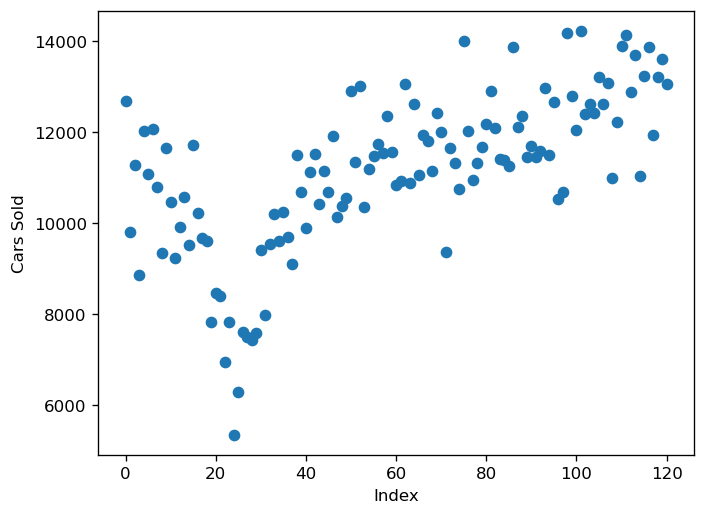

In [5]:
# Plot data for visualization
figure, ax = plt.subplots(dpi=120)
df.reset_index().plot(x = 'index', y = 'Quantity', style = 'o', legend = None, ax = ax)
plt.xlabel('Index')
plt.ylabel('Cars Sold')
plt.show()

In [6]:
# Create Date column
cols=["Year","Month"]
df['Date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
df['Date']=pd.to_datetime(df['Date'])
df.head()

,Year,Month,Quantity,Date
0,2007,1,12685,2007-01-01
1,2007,2,9793,2007-02-01
2,2007,3,11264,2007-03-01
3,2007,4,8854,2007-04-01
4,2007,5,12007,2007-05-01


Text(0, 0.5, 'Residual')

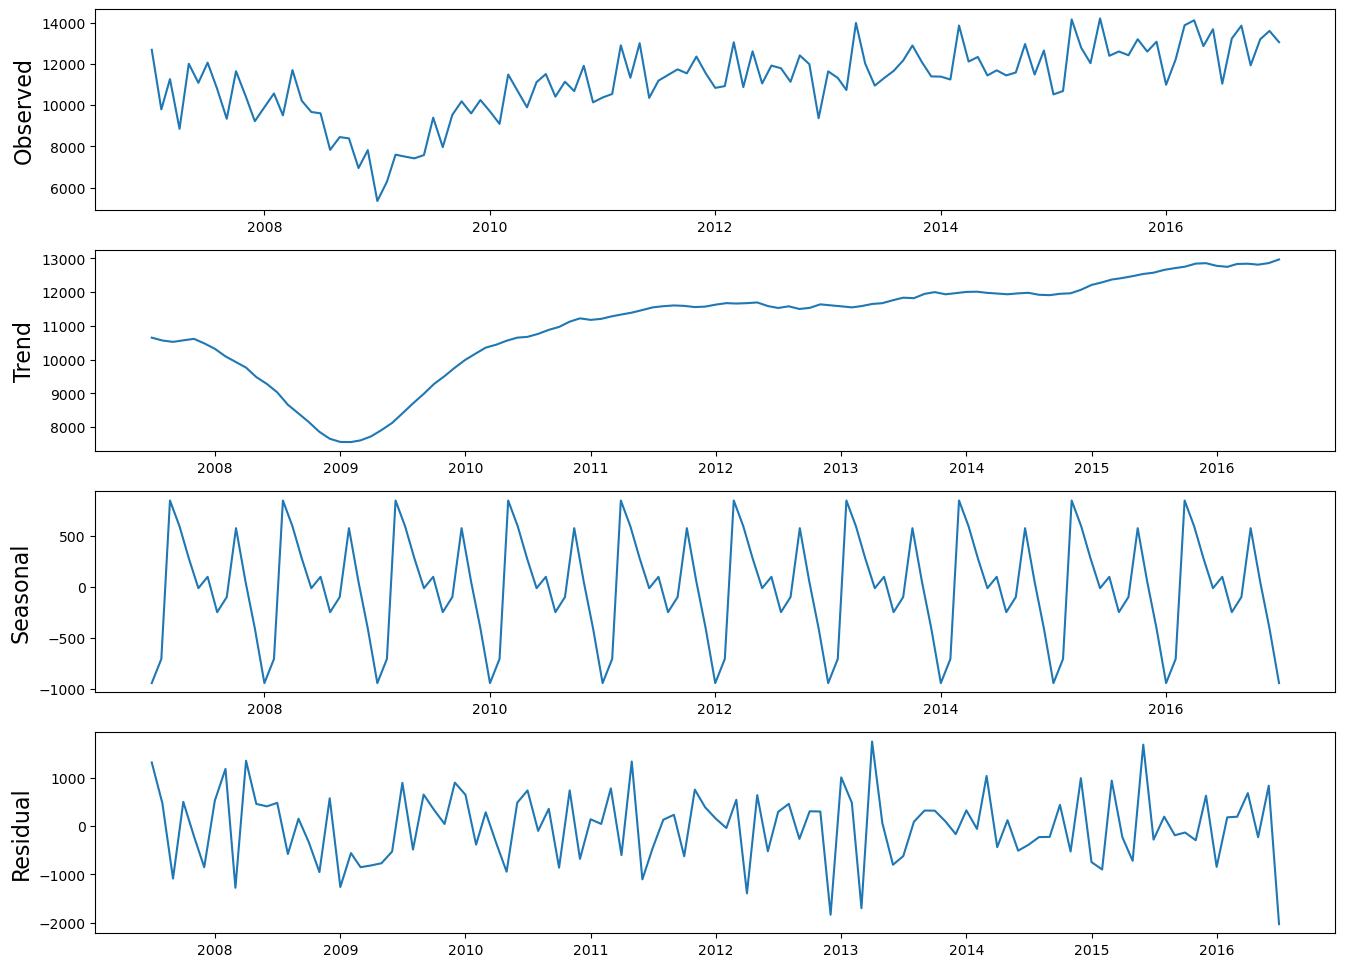

In [7]:
# Obtain Trend, Seasonality, and error features
df.set_index('Date', inplace=True)
analyze = df[['Quantity']].copy()
decomposed_data = seasonal_decompose(analyze)

# Set plot sizes and alignment
fig, ax = plt.subplots(4, 1, figsize=(16,12))

# Plot Observed, trend, seasonality, and residual plots
ax[0].plot(decomposed_data.observed);
ax[1].plot(decomposed_data.trend);
ax[2].plot(decomposed_data.seasonal);
ax[3].plot(decomposed_data.resid);

# Set plot labels
ax[0].set_ylabel('Observed', fontsize=16)
ax[1].set_ylabel('Trend', fontsize=16)
ax[2].set_ylabel('Seasonal', fontsize=16)
ax[3].set_ylabel('Residual', fontsize=16)

In [8]:
analyze.shape

(121, 1)

The plot shows that there is an increasing trend in general, and the number of cars sold increases over the months. However, there is a significant decrease for the number of cars sold between 2008 and 2009, this is the same period as the great recession which explains why the trend drops. Therefore, data normalization is needed to overcome these outliers. Also, the seasonality plot shows that at the beginning of a new year there is always a significant drop in the number of cars sold and almost no cars are sold during that time, this is because the holiday season is always around the new year, and no car sales are made during holidays.

In [8]:
dates = pd.date_range(start='2007-01-01', end='2017-01-01', freq='MS')
df['Month'] = [i.month for i in dates]
df['Year'] = [i.year for i in dates]
df.head()

,Year,Month,Quantity
Date,,,
2007-01-01,2007,1,12685
2007-02-01,2007,2,9793
2007-03-01,2007,3,11264
2007-04-01,2007,4,8854
2007-05-01,2007,5,12007


In [9]:
# Create One-hot encoding for the month column by converting month (int) values to text and then creating dummy variables
df['Month'] = pd.to_datetime(df['Month'], format='%m').dt.month_name()
# Visualize first five rows in the updated data
df.head()

,Year,Month,Quantity
Date,,,
2007-01-01,2007,January,12685
2007-02-01,2007,February,9793
2007-03-01,2007,March,11264
2007-04-01,2007,April,8854
2007-05-01,2007,May,12007


In [10]:
df = pd.get_dummies(df) # Can use get_dummies because all months are available in the dataset

# Reorder columns for better visualization
df = df[['Year','Quantity','Month_January','Month_February','Month_March','Month_April','Month_May','Month_June', 'Month_July',
   'Month_August','Month_September','Month_October','Month_November','Month_December']]

# Visualize first five rows in the updated data
df.head()

,Year,Quantity,Month_January,Month_February,Month_March,Month_April,Month_May,Month_June,Month_July,Month_August,Month_September,Month_October,Month_November,Month_December
Date,,,,,,,,,,,,,,
2007-01-01,2007,12685,1,0,0,0,0,0,0,0,0,0,0,0
2007-02-01,2007,9793,0,1,0,0,0,0,0,0,0,0,0,0
2007-03-01,2007,11264,0,0,1,0,0,0,0,0,0,0,0,0
2007-04-01,2007,8854,0,0,0,1,0,0,0,0,0,0,0,0
2007-05-01,2007,12007,0,0,0,0,1,0,0,0,0,0,0,0


In [11]:
# Create z-normalization function
def normalizeData(data, mean, std):
    normalized = (data-mean)/(std)
    return normalized

# Create denormalization function
def denormalizeData(normalized_data, mean, std):
    denormalized = (normalized_data*std)+(mean)
    return denormalized

In [12]:
# Split data into inputs and target
X = np.array(df.drop(["Quantity"],1))
y = np.array(df["Quantity"])

# Split data into training and test sets
n_train = math.floor(0.8 * X.shape[0]) # 80% training
n_test = math.ceil((0.2) * X.shape[0]) # 20% testing

# Training set Jan 2007- Dec 2014
X_train = X[:n_train]
y_train = y[:n_train]

# Testing set Jan 2015- Jan 2017
X_test = X[n_train:]
y_test = y[n_train:]

In [13]:
# Mean and standard deviation of training set
Xtrain_mean = np.mean(X_train)
Xtrain_std = np.std(X_train)
ytrain_mean = np.mean(y_train)
ytrain_std = np.std(y_train)

In [14]:
# Normalize data
Xtrain_norm = normalizeData(X_train, Xtrain_mean, Xtrain_std)
ytrain_norm = normalizeData(y_train, ytrain_mean, ytrain_std)
Xtest_norm = normalizeData(X_test, Xtrain_mean, Xtrain_std)
ytest_norm = normalizeData(y_test, ytrain_mean, ytrain_std)

## Step 3: SARIMA Model

In [15]:
# Combine train data together and test data together for SARIMA model
trainData = df[:n_train]
testData = df[n_train:]

In [16]:
# Normalize data for SARIMA
train_mean = np.mean(trainData)
train_std = np.std(trainData)
trainData_norm = normalizeData(trainData, train_mean, train_std)
testData_norm = normalizeData(testData, train_mean, train_std)

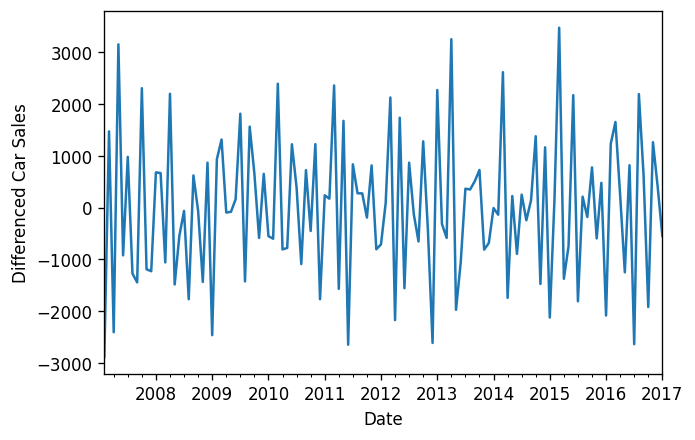

In [17]:
# Plot difference plot
diff_data = df['Quantity'].diff().dropna()

figure, ax = plt.subplots(dpi=120)
diff_data.plot(ax=ax)
plt.ylabel('Differenced Car Sales')
plt.show()

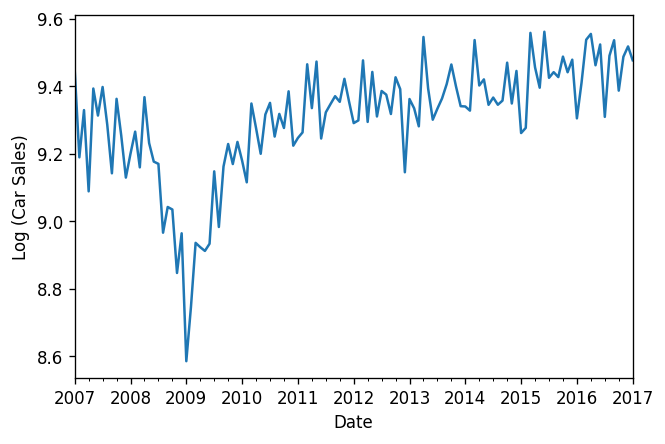

In [18]:
# Plot log10 plot
log_data = np.log(df['Quantity'])

figure, ax = plt.subplots(dpi=120)
log_data.plot(ax=ax)
plt.ylabel('Log (Car Sales)')
plt.show()

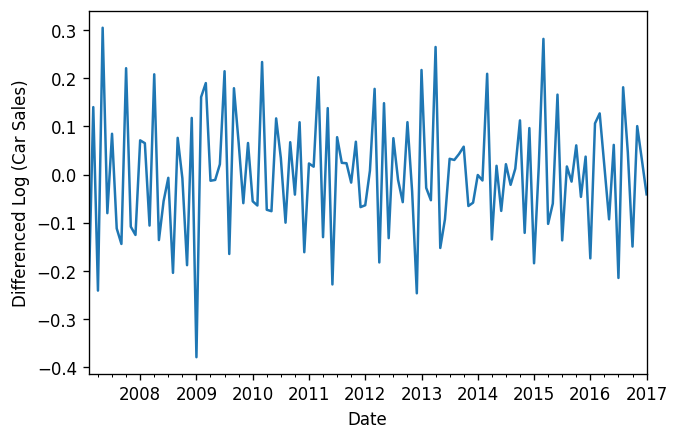

In [19]:
# Plot Diff log plot
Difflog_data = log_data.diff().dropna()

figure, ax = plt.subplots(dpi=120)
Difflog_data.plot(ax=ax)
plt.ylabel('Differenced Log (Car Sales)')
plt.show()

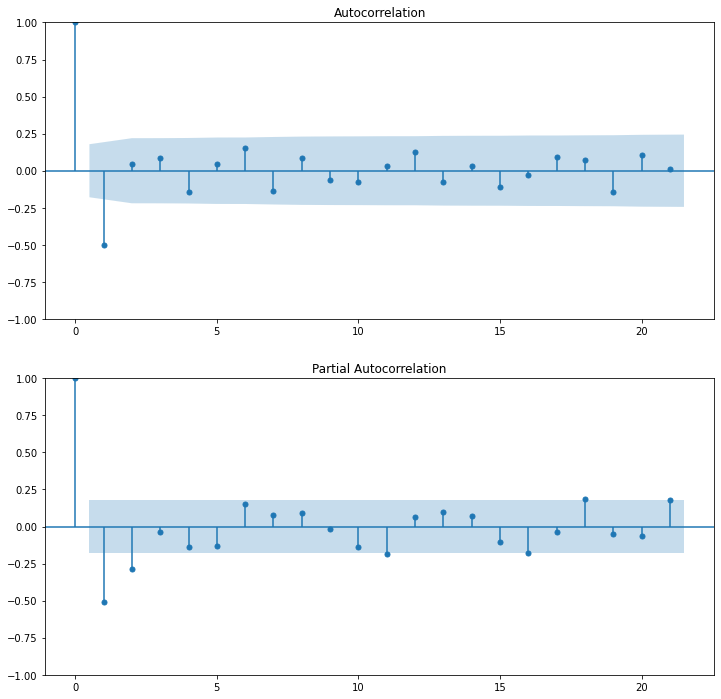

In [20]:
# Plot ACF and PACF plots
fig, ax = plt.subplots(2, 1, figsize=(12,12))
plot_acf(Difflog_data, ax=ax[0])
plot_pacf(Difflog_data, ax=ax[1])
plt.show()

#### This is cross-validation step for SARIMA

In [21]:
warnings.filterwarnings('ignore')

# K-fold splits for time series
tscv = TimeSeriesSplit(n_splits=5)

# Array to store values
SARIMA_cvscore = []

# Get training set only for Quantity attribute (analyze is previously defined and represents full Quantity column)
analyze = analyze[0:96]
# Normalize original quantity values
analyze = normalizeData(analyze, ytrain_mean, ytrain_std)

for train_index, test_index in tscv.split(analyze):
    cv_train, cv_test = analyze.iloc[train_index], analyze.iloc[test_index]
    model = SARIMAX(cv_train.Quantity, order=(1,1,1), seasonal_order=(1,0,0,12)).fit()
    predictions = model.predict(cv_test.index[0], cv_test.index[-1])
    true_values = cv_test.values
    SARIMA_cvscore.append(mean_absolute_percentage_error(true_values, predictions))
    
# MAPE cv-score for all folds
SARIMA_cvscore = np.mean(SARIMA_cvscore)

# Print result
print("Cross-Validation score for SARIMA model is: ", SARIMA_cvscore)

Cross-Validation score for SARIMA model is:  3.3727484784288406


In [22]:
warnings.filterwarnings('ignore')

# For the sake of this assignment, no parameter tuning is done, default values are used for (p,d,q) 
# and (P,D,Q)=(1,0,0,12) to add seasonality component
# Value of 12 is used because predicions are monthly. This uses normalized data
sarima = SARIMAX(trainData_norm.Quantity, 
                order=(1,1,1), 
                seasonal_order=(1,0,0,12))

# Fit and predict on training and testing data
predictionsTrain = sarima.fit().predict(trainData.index[0], trainData.index[-1])
predictionsTest = sarima.fit().predict(testData.index[0], testData.index[-1])

# Reverse normalization for the training outputs
predictionsTrain = predictionsTrain.to_frame()
predictionsTrain = denormalizeData(predictionsTrain['predicted_mean'].values, train_mean.Quantity, train_std.Quantity)

# Reverse normalization for the testing outputs
predictionsTest = predictionsTest.to_frame()
predictionsTest = denormalizeData(predictionsTest['predicted_mean'].values, train_mean.Quantity, train_std.Quantity)

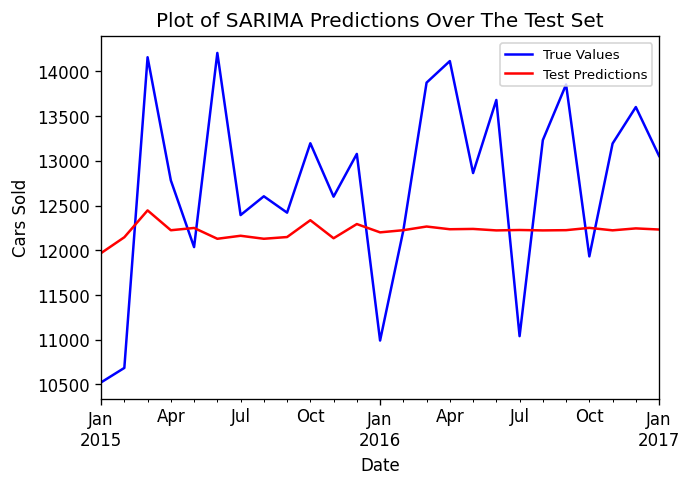

In [23]:
# Plot settings
fig, ax = plt.subplots(dpi=120)
custom_cycler = (cycler(color=['b','r']))
ax.set_prop_cycle(custom_cycler)

# Combine true and predicted values for plotting
predictionsTest = pd.Series(predictionsTest,index=testData.index)
predictionsTest = pd.DataFrame(predictionsTest,index = testData.index,columns=['Test Predictions'])
pd.concat([testData['Quantity'], predictionsTest],axis=1).plot(ax=ax)

# Set plot title and labels
plt.title("Plot of SARIMA Predictions Over The Test Set")
plt.ylabel("Cars Sold")
Leg = plt.legend(fontsize=8, loc='upper right')
Leg.get_texts()[0].set_text('True Values')

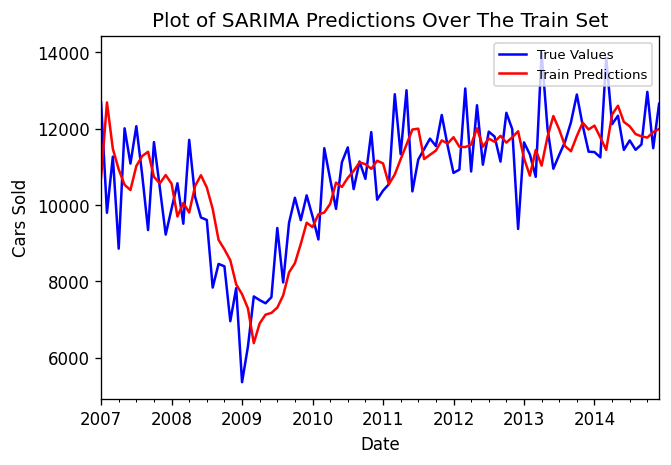

In [24]:
# Plot settings
fig, ax = plt.subplots(dpi=120)
custom_cycler = (cycler(color=['b','r']))
ax.set_prop_cycle(custom_cycler)

# Combine true and predicted values for plotting
predictionsTrain = pd.Series(predictionsTrain,index=trainData.index)
predictionsTrain = pd.DataFrame(predictionsTrain,index = trainData.index,columns=['Train Predictions'])
pd.concat([trainData['Quantity'], predictionsTrain],axis=1).plot(ax=ax)

# Set plot title and labels
plt.title("Plot of SARIMA Predictions Over The Train Set")
plt.ylabel("Cars Sold")
Leg = plt.legend(fontsize=8, loc='upper right')
Leg.get_texts()[0].set_text('True Values')

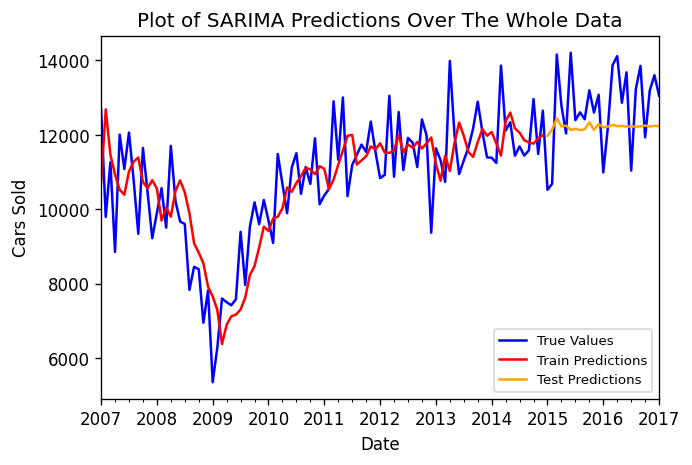

In [25]:
# Plot settings
fig, ax = plt.subplots(dpi=120)
custom_cycler = (cycler(color=['b','r','orange']))
ax.set_prop_cycle(custom_cycler)

predictionsAll = pd.concat([predictionsTrain, predictionsTest],axis=1)
pd.concat([df['Quantity'], predictionsAll],axis=1).plot(ax=ax)

# Set plot title and labels
plt.title("Plot of SARIMA Predictions Over The Whole Data")
plt.ylabel("Cars Sold")
Leg = plt.legend(fontsize=8, loc='lower right')
Leg.get_texts()[0].set_text('True Values')

In [26]:
# Calculate RMSE
SARIMA_RMSE= math.sqrt(mean_squared_error(testData['Quantity'].values, predictionsTest['Test Predictions'].values))

# Calculate MAE
SARIMA_MAE= mean_absolute_error(testData['Quantity'].values, predictionsTest['Test Predictions'].values)

# Calculate MAPE
SARIMA_MAPE = mean_absolute_percentage_error(testData['Quantity'].values, predictionsTest['Test Predictions'].values)*100

# Print results
print("The Testing RMSE value for the SARIMA model is: ", SARIMA_RMSE)
print("The Testing MAE value for the SARIMA model is: ", SARIMA_MAE)
print("The Testing MAPE value for the SARIMA model is: ", SARIMA_MAPE)

The Testing RMSE value for the SARIMA model is:  1140.3213672485203
The Testing MAE value for the SARIMA model is:  985.5310820952733
The Testing MAPE value for the SARIMA model is:  7.689189595932317


## Step 4: SVR Model

In [27]:
# Load SVR model; Parameters randomly chosen to get some sort of response as default values don't have any response
SVR_model = SVR(kernel='poly',gamma=0.7, C=50, epsilon = 0.5)

# K-fold splits for time series
tscv = TimeSeriesSplit(n_splits=5)

# Perform 5-fold cross-validation
SVR_cvscore=-cross_val_score(SVR_model,Xtrain_norm,ytrain_norm,cv=tscv,scoring='neg_mean_absolute_percentage_error').mean()

# Print result
print("Cross-Validation score for SVR model is: ", SVR_cvscore)

Cross-Validation score for SVR model is:  4.545506401670394


In [28]:
# Fit the model
SVR_model.fit(Xtrain_norm, ytrain_norm)

# Get normalized predictions on test data
SVR_predictions_norm_test = SVR_model.predict(Xtest_norm)
# Get normalized predictions on train data
SVR_predictions_norm_train = SVR_model.predict(Xtrain_norm)

# Reverse normalization for results
SVR_predictions_test = denormalizeData(SVR_predictions_norm_test, ytrain_mean, ytrain_std)
SVR_predictions_train = denormalizeData(SVR_predictions_norm_train, ytrain_mean, ytrain_std)

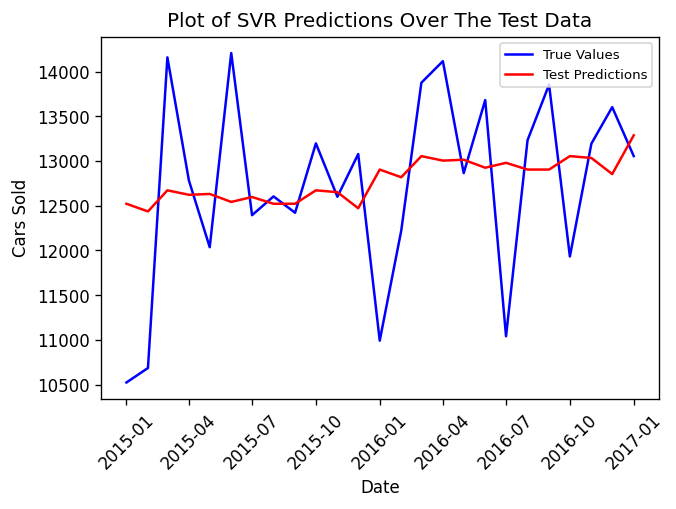

In [29]:
# Plot SVR predictions on test set
fig, ax = plt.subplots(dpi=120)
ax.plot(testData.index, y_test,'b-', label='True Values')
ax.plot(testData.index, SVR_predictions_test, '-', color='red', label='Test Predictions')
plt.title("Plot of SVR Predictions Over The Test Data")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Cars Sold")
plt.legend(fontsize=8, loc='upper right')
plt.show()

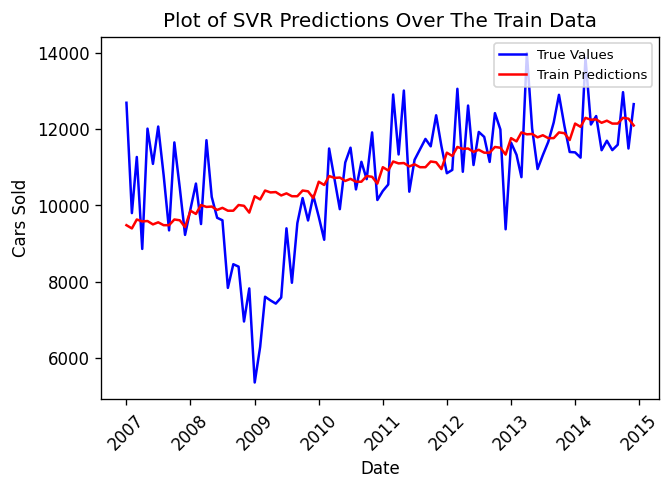

In [30]:
# Plot SVR predictions on train set
fig, ax = plt.subplots(dpi=120)
ax.plot(trainData.index, y_train,'b-', label='True Values')
ax.plot(trainData.index, SVR_predictions_train, 'r-', label='Train Predictions')
plt.title("Plot of SVR Predictions Over The Train Data")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Cars Sold")
plt.legend(fontsize=8, loc='upper right')
plt.show()

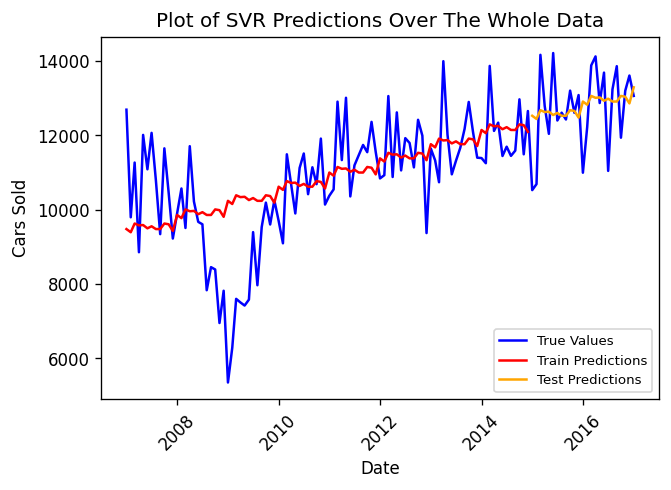

In [31]:
# Plot SVR predictions on whole data
fig, ax = plt.subplots(dpi=120)
ax.plot(df.index, df['Quantity'],'b-', label='True Values')
ax.plot(trainData.index, SVR_predictions_train, 'r-', label='Train Predictions')
ax.plot(testData.index, SVR_predictions_test, '-', color='orange', label='Test Predictions')
plt.title("Plot of SVR Predictions Over The Whole Data")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Cars Sold")
plt.legend(fontsize=8, loc='lower right')
plt.show()

In [32]:
# Calculate RMSE
SVR_RMSE = math.sqrt(mean_squared_error(testData['Quantity'].values, SVR_predictions_test))
# Calculate MAE
SVR_MAE = mean_absolute_error(testData['Quantity'].values, SVR_predictions_test)
# Calculate MAPE
SVR_MAPE = mean_absolute_percentage_error(testData['Quantity'].values, SVR_predictions_test)*100

# Print results
print("The Testing RMSE value for the SVR model is: ", SVR_RMSE)
print("The Testing MAE value for the SVR model is: ", SVR_MAE)
print("The Testing MAPE value for the SVR model is: ", SVR_MAPE)

The Testing RMSE value for the SVR model is:  1026.0080717715323
The Testing MAE value for the SVR model is:  802.1605877065523
The Testing MAPE value for the SVR model is:  6.539803442276303


## Step 5: XGBRegressor

In [33]:
# Load XGB model
XGB_model = XGB()

# K-fold splits for time series
tscv = TimeSeriesSplit(n_splits=5)

# Perform 5-fold cross-validation
XGB_cvscore=-cross_val_score(XGB_model,Xtrain_norm,ytrain_norm,cv=tscv,scoring='neg_mean_absolute_percentage_error').mean()

# Print result
print("Cross-Validation score for XGB model is: ", XGB_cvscore)

Cross-Validation score for XGB model is:  5.735834041268679


In [34]:
# Fit the model
XGB_model.fit(Xtrain_norm, ytrain_norm)

# Get normalized predictions on test data
XGB_predictions_norm_test = XGB_model.predict(Xtest_norm)
# Get normalized predictions on train data
XGB_predictions_norm_train = XGB_model.predict(Xtrain_norm)

# Reverse normalization for results
XGB_predictions_test = denormalizeData(XGB_predictions_norm_test, ytrain_mean, ytrain_std)
XGB_predictions_train = denormalizeData(XGB_predictions_norm_train, ytrain_mean, ytrain_std)

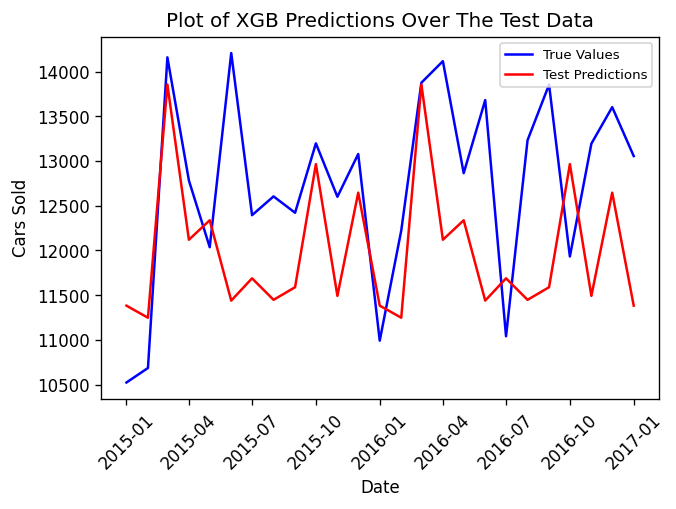

In [35]:
# Plot XGB predictions on test set
fig, ax = plt.subplots(dpi=120)
ax.plot(testData.index, y_test,'b-', label='True Values')
ax.plot(testData.index, XGB_predictions_test, '-', color='red', label='Test Predictions')
plt.title("Plot of XGB Predictions Over The Test Data")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Cars Sold")
plt.legend(fontsize=8, loc='upper right')
plt.show()

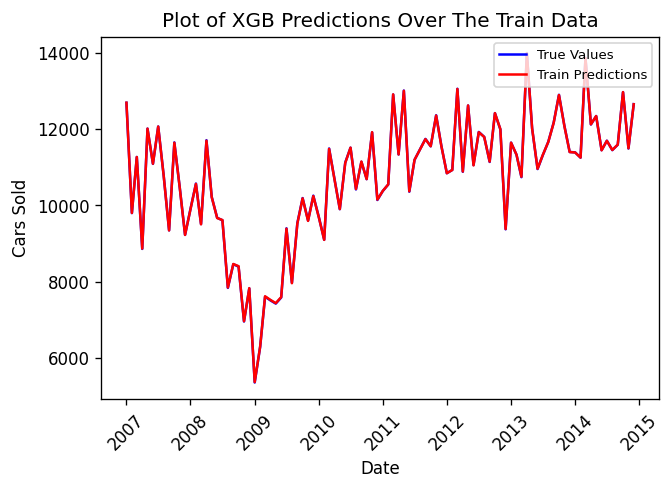

In [36]:
# Plot XGB predictions on train set
fig, ax = plt.subplots(dpi=120)
ax.plot(trainData.index, y_train,'b-', label='True Values')
ax.plot(trainData.index, XGB_predictions_train, 'r-', label='Train Predictions')
plt.title("Plot of XGB Predictions Over The Train Data")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Cars Sold")
plt.legend(fontsize=8, loc='upper right')
plt.show()

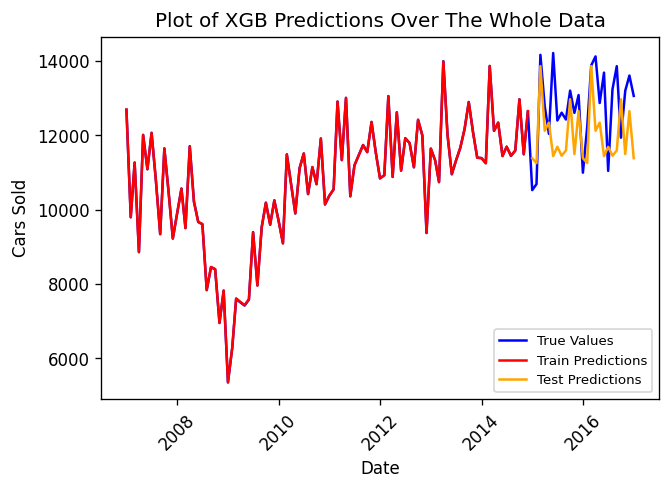

In [37]:
# Plot XGB predictions on whole data
fig, ax = plt.subplots(dpi=120)
ax.plot(df.index, df['Quantity'],'b-', label='True Values')
ax.plot(trainData.index, XGB_predictions_train, 'r-', label='Train Predictions')
ax.plot(testData.index,XGB_predictions_test, '-', color='orange', label='Test Predictions')
plt.title("Plot of XGB Predictions Over The Whole Data")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Cars Sold")
plt.legend(fontsize=8, loc='lower right')
plt.show()

In [38]:
# Calculate RMSE
XGB_RMSE_train = math.sqrt(mean_squared_error(trainData['Quantity'].values, XGB_predictions_train))
# Calculate MAE
XGB_MAE_train = mean_absolute_error(trainData['Quantity'].values, XGB_predictions_train)
# Calculate MAPE
XGB_MAPE_train = mean_absolute_percentage_error(trainData['Quantity'].values, XGB_predictions_train)*100

# Print results
print("The Training RMSE value for the XGB model is: ", XGB_RMSE_train)
print("The Training MAE value for the XGB model is: ", XGB_MAE_train)
print("The Training MAPE value for the XGB model is: ", XGB_MAPE_train)

The Training RMSE value for the XGB model is:  6.9866448363410765
The Training MAE value for the XGB model is:  5.8579762776692705
The Training MAPE value for the XGB model is:  0.05943235266253365


In [39]:
# Calculate RMSE
XGB_RMSE = math.sqrt(mean_squared_error(testData['Quantity'].values, XGB_predictions_test))
# Calculate MAE
XGB_MAE = mean_absolute_error(testData['Quantity'].values, XGB_predictions_test)
# Calculate MAPE
XGB_MAPE = mean_absolute_percentage_error(testData['Quantity'].values, XGB_predictions_test)*100

# Print results
print("The Testing RMSE value for the XGB model is: ", XGB_RMSE)
print("The Testing MAE value for the XGB model is: ", XGB_MAE)
print("The Testing MAPE value for the XGB model is: ", XGB_MAPE)

The Testing RMSE value for the XGB model is:  1267.2581639564924
The Testing MAE value for the XGB model is:  1045.542421875
The Testing MAPE value for the XGB model is:  8.063796818558322
